# Portfolio Analyzer overview

Portfolio Analyzer is a python library built to make easy portfolio analysis. In this Notebook we are going to see few examples. First things first. You can install Portfolio Analyzer with pip, so

In [1]:
#%%bash
#pip install git+https://github.com/Tokukawa/PortfolioAnalyzer.git

The first thing we need in order to analyze porfolio is data. We can use the function `yahoo2pandas`. This function take a list of tickers and return a pandas dataframe

In [2]:
from portfolio_analyzer.stocks_data_loader import yahoo2pandas

In [3]:
tickers = ['SPXL', 'TMF', 'UGL']
data = yahoo2pandas(tickers, frequency='daily')

In [4]:
data.head()

,SPXL,TMF,UGL
formatted_date,,,
2009-04-16,2.415000,14.5350,29.920000
2009-04-17,2.470000,13.8850,29.440001
2009-04-20,2.152500,14.7275,30.690001
2009-04-21,2.278333,14.2825,30.559999
2009-04-22,2.237500,13.7950,30.889999


By default `yahoo2pandas` return all possible data from yahoo. You can specify range of time you want and the frequency. Once we obtained the data, we can optimize our portfolio according to some most common algorithms. Up this moment you can use only `minimal_variance`, `risk_parity` and `approximated_max_kelly`.

In [5]:
from portfolio_analyzer.optimizers import approximated_max_kelly, minimal_variance, risk_parity

In [6]:
minimal_variance(data)

,SPXL,TMF,UGL
0,0.30152,0.347228,0.351252


In [7]:
risk_parity(data)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0381063068140511e-13
            Iterations: 18
            Function evaluations: 90
            Gradient evaluations: 18


,SPXL,TMF,UGL
0,0.312898,0.346142,0.340959


In [8]:
approximated_max_kelly(data)

,SPXL,TMF,UGL
0,0.307769,0.350654,0.341577


We can see how our portfolio would perform with `NaiveBackTest`.

In [9]:
from portfolio_analyzer.backtest import NaiveBackTest
from portfolio_analyzer.utils import portfolio2dic

In [10]:
my_portfolio = portfolio2dic(approximated_max_kelly(data))

In [11]:
backtest = NaiveBackTest(my_portfolio, data)

In [12]:
risk_parity_backtest = backtest.run()

We can perform some measures on the back test and we can plot it.

In [13]:
%matplotlib inline
from portfolio_analyzer.metrics import MainMetrics

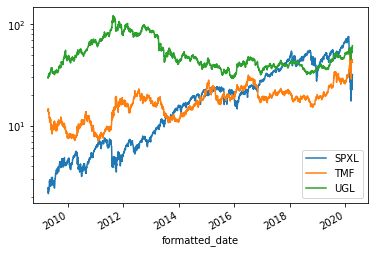

In [14]:
data.plot(logy=True)

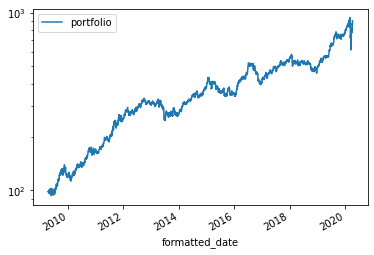

In [15]:
risk_parity_backtest.plot(logy=True)

In [16]:
benchmark_data = yahoo2pandas(['VTI'], frequency='daily')
measures = MainMetrics(benchmark=benchmark_data)

In [17]:
MainMetrics(benchmark_data).estimate(risk_parity_backtest)

,portfolio
alpha,0.146374
average arithmetic return,0.225571
average geometric return,0.223740
benchmark correlation,0.425989
beta,0.524360
max draw down,-0.341702
relative draw down,0.976284
relative return,2.002532
relative sharpe ratio,1.508135
relative variance,1.515474


But I want to perform a proper out-of-sample back test before rebalancing my portfolio. We can use the class `OutOfSampleBackTest`. First of all we need to know how many times we can split the dataset.

In [18]:
import pandas as pd
from portfolio_analyzer.utils import factors

Before starting my out of sample back test I neee to know how many eway I can split my data. I can know it with `factors` function 

In [31]:
factors(len(data))

[1, 2, 3, 6, 461, 922, 1383, 2766]

I can split my data in all the factors shown above!

In [38]:
SPLITS = 461

Now we can make a proper outofsample backtest.

In [21]:
from portfolio_analyzer.backtest import OutOfSampleBackTest

In [33]:
oos_backtest = OutOfSampleBackTest(data, minimal_variance, SPLITS, past_blocks=3, method='asym-blocks')

In [34]:
out_of_sample_portfolio = oos_backtest.run()

In [35]:
MainMetrics(benchmark_data).estimate(out_of_sample_portfolio)

,portfolio
alpha,0.155106
average arithmetic return,0.227778
average geometric return,0.228400
benchmark correlation,0.360997
beta,0.402683
max draw down,-0.298444
relative draw down,0.852689
relative return,1.705599
relative sharpe ratio,1.422778
relative variance,1.248942


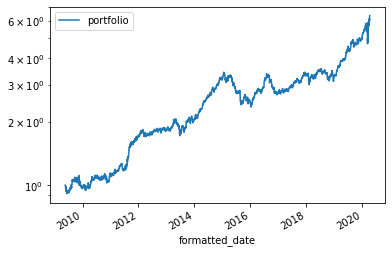

In [43]:
out_of_sample_portfolio.plot(logy=True)

I can even define my own strategy!

In [36]:
def custom_portfolio(data):
    return pd.DataFrame({'SPXL': [0.36], 'TMF':[0.48], 'UGL':[0.16]})

In [39]:
oos_backtest = OutOfSampleBackTest(data, custom_portfolio, SPLITS, past_blocks=3, method='asym-blocks')

In [40]:
out_of_sample_portfolio = oos_backtest.run()

We can get the actual out of sample performance the same way we did before.

In [41]:
MainMetrics(benchmark_data).estimate(out_of_sample_portfolio)

,portfolio
alpha,0.158637
average arithmetic return,0.224396
average geometric return,0.226516
benchmark correlation,0.338256
beta,0.362374
max draw down,-0.316818
relative draw down,0.905188
relative return,1.691530
relative sharpe ratio,1.463229
relative variance,1.146035


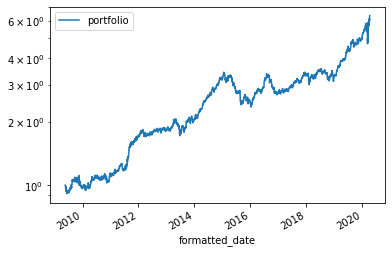

In [42]:
out_of_sample_portfolio.plot(logy=True)

I can even detect trends. For trend detection we can use the function l1filter.

In [67]:
from portfolio_analyzer.filtering import l1filter

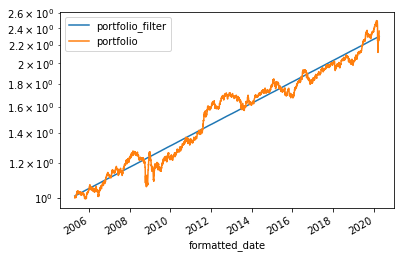

In [73]:
filtered, test = l1filter(out_of_sample_portfolio, delta=1E5)
filtered.plot(logy=True)

In [74]:
filtered.head()

,portfolio_filter,portfolio
formatted_date,,
2005-04-21,1.009702,1.000000
2005-04-22,1.009941,1.002737
2005-04-25,1.010180,1.007550
2005-04-26,1.010419,1.003945
2005-04-27,1.010658,1.005187


Whenever we perform a trend detection the test of stationarity is performed on the residuals. We can see the statistics as a pandas dataframe.

In [75]:
test['portfolio']

,portfolio
ADF Test Statistic,-3.315191
P-Value,0.014213
Lags Used,16.000000
Observations Used,3463.000000
Critical Value (1%),-3.432240
Critical Value (5%),-2.862375
Critical Value (10%),-2.567214


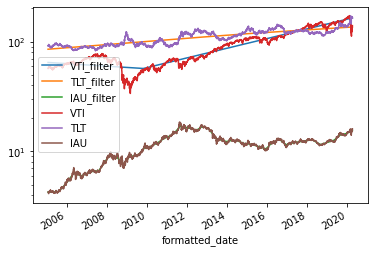

In [71]:
filtered, test = l1filter(data, delta=[1E4, 1E4, 1E1])
filtered.plot(logy=True)

In [58]:
test.keys()

dict_keys(['VTI', 'TLT', 'IAU'])

In [59]:
test['VTI']

,VTI
ADF Test Statistic,-3.007341
P-Value,0.034215
Lags Used,18.000000
Observations Used,3807.000000
Critical Value (1%),-3.432069
Critical Value (5%),-2.862299
Critical Value (10%),-2.567174
